# Two qubit operations

In [19]:
from qiskit import (QuantumCircuit,
                        QuantumRegister,
                        ClassicalRegister,
                        execute,
                        Aer)
import numpy as np
from qiskit.visualization import plot_histogram

In [20]:
from qiskit import transpile
qc = QuantumCircuit(1)
qc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0)
print(qc)
new_qc = transpile(qc, basis_gates=["cx", "u3"])
print(new_qc)

     ┌─────────────────────────────┐
q_0: ┤ initialize(0.70711,0.70711) ├
     └─────────────────────────────┘
     ┌──────────────┐
q_0: ┤ U3(pi/2,0,0) ├
     └──────────────┘


In [21]:
def show_result(qc, histogram = False):
    job = execute(qc, backend = Aer.get_backend("statevector_simulator"))
    vec = job.result().get_statevector(qc)
    
    bins = [format(i, '0%db'%np.ceil(np.log2(len(vec)))) for i, _ in enumerate(vec)]
    for i, j in zip(vec, bins):
        print(i, ": |%s>"%str(j))
    if histogram:
        display(plot_histogram(job.result().get_counts()))
        display(qc.draw(output = 'mpl'))

### Q1. Create state 
$$|\psi_0\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

In [22]:
qc = QuantumCircuit(2, 2)

qc.h(0)
qc.cx(0, 1)

show_result(qc)

(0.7071067811865476+0j) : |00>
0j : |01>
0j : |10>
(0.7071067811865475+0j) : |11>


### Q2. Create state 
$$|\psi_0\rangle = \frac{|01\rangle + |10\rangle}{\sqrt{2}}$$

In [23]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

qc.h(0)
qc.cx(0, 1)
qc.x(0)

show_result(qc)

0j : |00>
(0.7071067811865476+0j) : |01>
(0.7071067811865475+0j) : |10>
0j : |11>


### Q3. Validate CHSH inequality (A little bit advanced)
What is CHSH inequality? https://en.wikipedia.org/wiki/CHSH_inequality  
Briefly, CHSH inequality is a proof of bell's theorem.   
Usually, CHSH inequality satisfies
$$|\langle{A, B}\rangle-\langle{a, B}\rangle+\langle{A, b}\rangle + \langle{a, b}\rangle| \leq 2$$  
in a classical system. However, in a quantum system, this inequality satisfies
$$2 < |\langle{A, B}\rangle-\langle{a, B}\rangle+\langle{A, b}\rangle + \langle{a, b}\rangle|\leq2\sqrt{2}$$  
A, B, a, b represent the basis of measurement.

#### First step (prepare quantum circuit)
We need two qubits to simulate CHSH inequality.

In [24]:
def create_qc():
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure(0, 0)
    return qc

#### Second step (prepare bell state)
Bell state is one of the most important quantum states. There are four types of bell states.
$$|\psi^{+}\rangle = \frac{|00\rangle+|11\rangle}{\sqrt{2}}$$
$$|\psi^{-}\rangle = \frac{|00\rangle-|11\rangle}{\sqrt{2}}$$
$$|\phi^{+}\rangle = \frac{|01\rangle+|10\rangle}{\sqrt{2}}$$
$$|\phi^{-}\rangle = \frac{|01\rangle-|10\rangle}{\sqrt{2}}$$
Choose one of them and prepare it on the circuit.

In [25]:
# The first one, because we already did that in Q1
show_result(create_qc())

(1+0j) : |00>
0j : |01>
0j : |10>
0j : |11>


#### Third step (Measurement basis)
Prepare four measurement basis.  
A = Z  
a = X  
B = $\frac{Z+X}{\sqrt{2}}$  
b = $\frac{Z-X}{\sqrt{2}}$  
In the qiskit, measurement basis is Z if you don't apply any operations.
To change the measurement basis, you need to apply operations before measurement.  
Hint: This is the basis of B
![Bbasis](./image/Bbasis.png)
You have to calculate one state with four basis.
Fill this table.

|Basis\Outcome |$P(|00\rangle)$ | $P(|01\rangle)$ | $P(|10\rangle)$ | $P(|11\rangle)$ |
|-------------|----------------------|----------------------|----------------------| ----------------------|
| AB          | 0.5                  | 0                    | 0                    | 0.5                   |
| aB          | 0.125                | 0.5                  | 0.250                | 0.125                 |
| Ab          | 0.25                 | 0                    | 0                    | 0.750                 |
| ab          | 0                    | 0.375                | 0.625                | 0                     |

AB (A = Z, B = described above)
0j : |00>
0j : |01>
0j : |10>
(-0.38268343236508956+0.9238795325112867j) : |11>


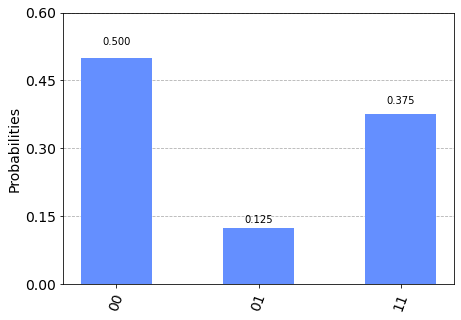

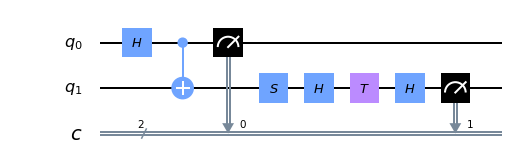

aB (a = X, B = described above)
0j : |00>
0j : |01>
(-0.38268343236508956+0.9238795325112867j) : |10>
0j : |11>


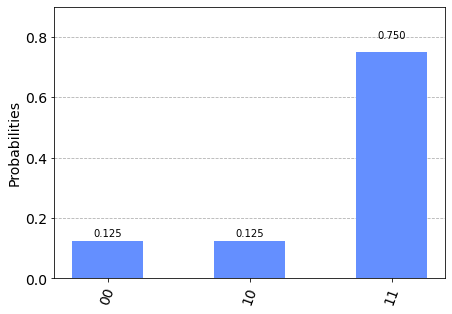

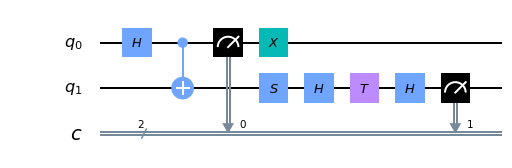

Ab (A = Z, b = (Z - X)/sqrt(2))
0j : |00>
0j : |01>
0j : |10>
(0.3826834323650901+0.9238795325112866j) : |11>


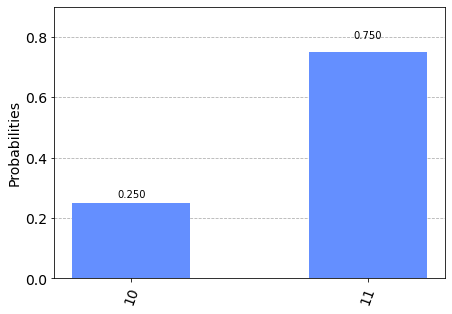

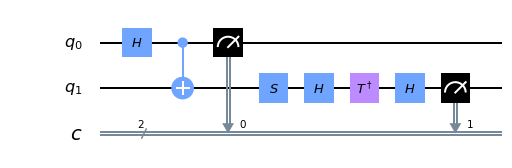

ab (a = X, b = (Z - X)/sqrt(2))
0j : |00>
(0.9238795325112866-0.38268343236508967j) : |01>
0j : |10>
0j : |11>


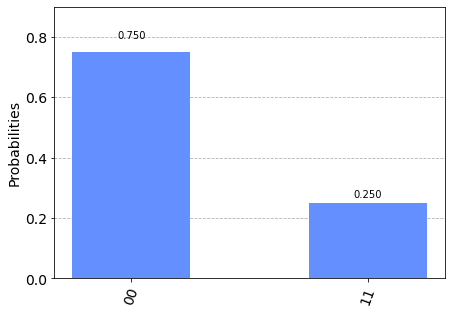

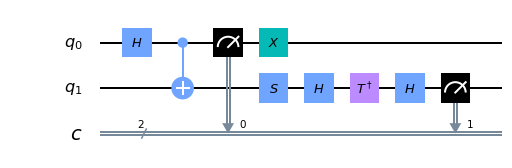

In [26]:
print('AB (A = Z, B = described above)')
qc = create_qc()
# A
# qc.z(1)

# B
qc.s(1)
qc.h(1)
qc.t(1)
qc.h(1)
qc.measure(1, 1)
# print(qc.draw())
show_result(qc, True)

print('aB (a = X, B = described above)')
qc = create_qc()
# a
qc.x(0)

# B
qc.s(1)
qc.h(1)
qc.t(1)
qc.h(1)
qc.measure(1, 1)
# print(qc.draw())
show_result(qc, True)

print('Ab (A = Z, b = (Z - X)/sqrt(2))')
qc = create_qc()
# A
# qc.z(1)

# b
qc.s(1)
qc.h(1)
qc.tdg(1) # Apparently, this is the opposite of the T gate
qc.h(1)
qc.measure(1, 1)
# print(qc.draw())
show_result(qc, True)


print('ab (a = X, b = (Z - X)/sqrt(2))')
qc = create_qc()
# a
qc.x(0)

# b
qc.s(1)
qc.h(1)
qc.tdg(1)
qc.h(1)
qc.measure(1, 1)
# print(qc.draw())
show_result(qc, True)

#### Final step (Calculate S value)
Finally, we need to calculate S value.
If you chose $|\psi^+\rangle$ or  $|\psi^-\rangle$, calculate $$\langle{MN}\rangle =  P(|00\rangle)+P(|11\rangle)-P(|01\rangle)-P(|10\rangle)$$   
else you chose $|\phi^+\rangle$ or $|\phi^+\rangle$, then you need to  
$$\langle{MN}\rangle = P(|01\rangle)+P(|10\rangle)-P(|00\rangle)-P(|11\rangle)$$
for each of basis.
And $$S = |\langle{AB}\rangle-\langle{aB}\rangle+\langle{Ab}\rangle+\langle{ab}\rangle|$$

In [28]:
AB = 0.5 + 0.375 - 0.125
aB = 0.125 + 0.75 - 0.125
Ab = 0.75 - 0.25
ab = 0.75 + 0.25

print(abs(AB - Ab + aB + ab))

2.0
